# Predicting Box Office Earnings
Aditya Ranade, Akshat Jain, Kevan Dodhia

For our project, we decided to predict gross box office earnings based on pre-release movie information and data. We use a 3-hidden layer neural network with a dataset of 10078 movies consisting of 11 features - Studio, Budget, Theatres Playing, Similar Movie Rating, Cast Rating, Director Rating, Release Season, youtube trailer likes, dislikes, views and comment sentiment analysis. 

Our work consisted of collecting relevant data from different sources, creating and transforming features indicative of earnings, and finally training an appropriate model for accurate prediction. 

## Data Collection

The first and probably most important question we had to answer was what features will be most indicative of the success of a movie in terms of box office earnings. Previous research (http://cs229.stanford.edu/proj2016/report/PengdaLiu-MachineLearningOnPredictingGrossBoxOffice-report.pdf) in this area has relied on using cast members, google hits, budget and season of release to predict earnings to decent accuracy. We wanted to expand on this research by collecting more information about a movie before its release. 

We chose 3 sources for our raw data:
   
> **Box Office Mojo** - Gross Earnings, Opening Earnings, Release date, Studio, Theatres showing
   
> **Youtube Trailer** - Comments, likes, dislikes, views
   
> **The Movie Database** - Cast, Director, Similar Movies, Genre, Budget

Below, we show how we extracted all this raw data for use in feature engineering.


### Box Office Earnings

We extracted our labeled dataset of movies with their earnings from boxofficemojo.com. The website includes movies from the year 2002-2018 with their Gross Earnings, Opening Earnings, Studio, Theatres and Release date. 

We scraped this data using the Python BeautifulSoup library and formed our initial dataset in the form of a pandas DataFrame. 


In [4]:
url_wo_date = "http://www.boxofficemojo.com/yearly/chart/?page=1& \
                    view=releasedate&view2=domestic&yr=%d&sort=gross&order=ASC&p=.htm"

url_wo_page = "http://www.boxofficemojo.com/yearly/chart/?page=%d&view=releasedate& \
                    view2=domestic&yr=%d&sort=gross&order=ASC&p=.htm"

def get_box_office_data():
    movie_data = []
    for year in years:
        print(year)
        url = url_wo_date % (year)
        response = get(url)
        text = response.text
        soup = bs(text, 'html.parser')
        table = soup.find_all('font', attrs= {"face":"Verdana", "size":"4"})
        number_pages = table[0].text.encode('ascii', 'ignore').decode('ascii')
        number_pages = len(number_pages.split(' - '))
        for i in range(number_pages):
            url = url_wo_page % (i+1, year)
            response = get(url)
            text = response.text
            soup = bs(response.text, 'html.parser')
            table = soup.find_all('table', attrs= {"cellspacing": "1", "cellpadding": "5", "bgcolor":"#ffffff"})[0]
            data_rows = table.find_all('td')
            data = [row.text.encode('ascii', 'ignore').decode('ascii') for row in data_rows]
            movie_data.extend(data[data.index("Close") + 1:-16])
    return movie_data


Below is the dataset we created above. It consists of 10078 labelled examples of movies.

In [59]:
df = pd.read_pickle("movie_df.pkl")
display(df[0:10])
print("Examples =", len(df))

,Movie Title,Studio,Gross Earnings,Total Theatres,Opening Earnings,Opening Theatres,Release Date,Close Data
0,'R Xmas,Path.,$850,1,$850,1,11/8,11/10
1,Lonely Affair of the Heart,Path.,$932,1,$932,1,9/27,-
2,The Jimmy Show,First,"$1,000",1,$703,1,12/13,12/19
3,Besotted,AL,"$1,379",1,$656,1,11/1,11/14
4,Execution of Wanda Jean,7Art,"$1,386",1,"$1,386",1,9/6,-
5,Heartbreak Hospital,7Art,"$1,480",1,"$1,480",1,9/6,-
6,Blackwoods,Boll,"$1,500",5,"$1,500",5,5/10,-
7,Mama Africa,Wells,"$1,581",2,"$1,581",2,6/7,-
8,The Opera Lover,Outr.,"$1,798",2,"$1,167",2,9/27,10/3
9,By Hook or by Crook,AL,"$1,802",2,"$1,802",2,10/25,-


Examples = 10078


### Youtube Trailer Data

In order to get youtube trailer information, we queried the Youtube API. For each movie, we first used the youtube.search() feature, which returns a list of videos that match the search term. We sorted the videos by relevence and picked the top video. So for instance if we wanted to get the youtube trailer video ID for "Mulholland drive", we pass in the following query into the youtube.search() method: "Mulholland drive official trialer".

                    query = movie_name + ' offitial trailer'
                    
                    results = youtube.search().list(
                        part='snippet',
                        maxResults=1,
                        q=query,
                        type='video',
                        order='relevance'
                    ).execute()

Once we get a youtube trailer ID for the movie, we proceed to get video statistics and comment information for the trailer. In order to get video statistics such as likes, dislikes and views, we used the youtube.videos().list() feature. This method returns video information for a given query (we use video_id to query this method).

                    results = youtube.videos().list(
                        part='statistics',
                        id=video_id
                    ).execute()

In order to get a list of the comments, we use the youtube.commentThreads().list() feature. We query the top 500 relevant comments and store the relevant information for each comment. Each query to youtube.commentThreads().list() has a limit of 100 comments, so we need to iteratively call the method until we get min(total_comments, 500) comments. 
                    
                    results = youtube.commentThreads().list(
                        part="snippet",
                        videoId=video_id,
                        textFormat="plainText",
                        order="relevance",
                        pageToken=pageToken,
                        maxResults=maxResults
                    ).execute()

We get the following dataset.

<img src="i.jpg">

### Movie Data

After scraping our movies from __[BoxOfficeMojo](www.boxofficemojo.com)__, we then got additional details of the movies using __[The Open Movie Database API](https://www.themoviedb.org/)__ which is an open source movie database that provides us with movie information. We used a Python wrapper called tmdb3vapi for the API which can be found __[here](https://github.com/AnthonyBloomer/tmdbv3api)__. We queried the API using the movie title and got additional information for it like the cast, genre, director and similar movies. All of this information was then stored into our previous database using Pandas.

This is the function we used to query the database for the movie based on id. 


In [67]:
from tmdbv3api import Movie,TMDb,Person
tmdb = TMDb()
tmdb.api_key = 'API_KEY'
movie = Movie()
columns = ['id','imdb_id','name','genres', 'budget', 'popularity', 'production_companies','directing','cast','adult','similar']

def get_tmdb_movie_data(id):
    movie = Movie()
    # Get details of movie as well as the credits
    m = movie.details(id)
    c = movie.credits(id)
    genres = []
    # Save genres
    for elem in m.genres:
        genres.append(elem['id'])
    production_companies = []
    # Save Production Companies
    for elem in m.production_companies:
        production_companies.append(elem['id'])
    # Save Cast and Directors
    cast = []
    directing = []
    for elem in c.cast:
        # Get top 5 cast members
        if (elem['order']<5):
            cast.append(elem['id'])
    for elem in c.crew:
        if (elem['job'] == 'Director'):
            directing.append(elem['id'])
    # Get similar movies
    similar = movie.similar(id)
    check = []
    if (len(elems)>0):
        for result in similar:
            check.append(result)
    # Save Everything in the form of a dictionary and return
    data = {'id': m.id, 'imdb_id' : m.imdb_id, 'name' : m.original_title, 'genres' : genres, 'budget' : m.budget,
             'popularity' : m.popularity, 'production_companies' : production_companies , 'cast' : cast,
            'directing' :directing,'adult': m.adult,'similar': check}
    return data

Below is the dataset we created.

In [69]:
movie_db = pd.read_pickle('final_db5.pkl')
display(movie_db[0:10])

,adult,budget,cast,directing,genres,id,imdb_id,name,popularity,production_companies,similar
0,False,0,"[70767, 17917, 21411, 944510, 2561]",[39104],"[18, 53]",49110.0,tt0217978,'R Xmas,1.018308,[11860],[<tmdbv3api.as_obj.AsObj object at 0x103b1b9e8...
1,False,0,"[11805, 17832, 569, 8792, 1178527]",[11805],"[35, 18]",99826.0,tt0271020,The Jimmy Show,0.121261,[921],[<tmdbv3api.as_obj.AsObj object at 0x114a02dd8...
2,False,0,[],[592891],[],277415.0,tt0220331,Besotted,0.001209,[],[<tmdbv3api.as_obj.AsObj object at 0x114a31898...
3,False,0,[],[96199],[99],26780.0,tt0303282,The Execution of Wanda Jean,0.196764,[],[<tmdbv3api.as_obj.AsObj object at 0x114a37278...
4,False,0,"[1008376, 1276, 6200]",[1008375],"[35, 10749]",96218.0,tt0219756,Heartbreak Hospital,0.343564,[],[]
5,False,3000000,"[41687, 42710, 60649, 60650, 15661]",[23799],[53],30779.0,tt0279695,Blackwoods,0.568657,[],[]
6,False,0,"[33162, 225931, 1076607, 1076608]",[54767],"[18, 99]",122140.0,tt1543029,Mama Africa,0.380056,[],[]
7,False,0,[],[],[],291644.0,tt0266820,The Opera Lover,0.001298,[],[]
8,False,0,"[104980, 974801, 220114, 1039105]",[1033840],"[35, 27, 80]",521595.0,tt0268877,A garrote limpio,0.299875,[],[]
9,False,0,[3711],[],[18],79923.0,tt0298071,Mr. Smith Gets a Hustler,0.118456,[],[]


## Feature Engineering and Pre-Processing

The data we collected was not ready to be used for model training yet. Features such as cast members, directors, comments, similar movies and realease date had to be transformed into a more usable and valuable form to get any signal from them. 

We decided to form the following features based on this raw data. 

> **cast_rating** - The popularity of the cast of a movie greatly influences the box office earnings of the movie. So we decided to form a new feature cast_rating which would be the average of the popularity score of the top 5 cast members in the movie. We extracted this popularity score by querying the TMDB API for the actors in each movie in our dataset. 

> **director_rating** - Similar to the above feature, we formed popularity score of the director for each movie in our dataset.

> **sentiment_score** - Explained below.

> **similar_movie_rating** - We used the average gross earnings of similar movies to form this this feature.

> **release_season** - We noticed that movie earnings were correlated with release season instead of particular dates. Below, we show a bar graph of average earnings by month and by season. 

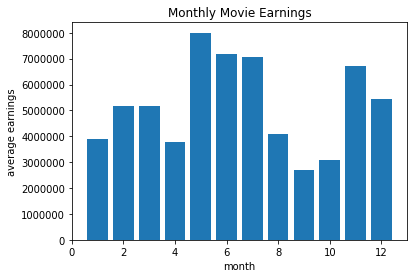

In [63]:
plt.bar(month_earnings.keys(), month_earnings.values())
plt.ylabel("average earnings")
plt.xlabel("Month")
plt.title("Monthly Movie Earnings")
plt.show()

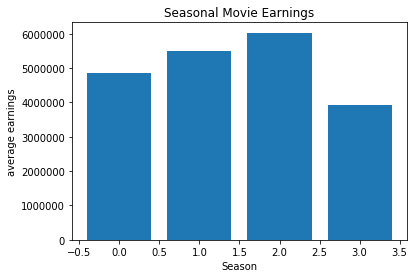

In [64]:
plt.bar(season_earnings.keys(), season_earnings.values())
plt.ylabel("average earnings")
plt.xlabel("Season")
plt.title("Seasonal Movie Earnings")
plt.show()

We noticed that the features - likes, dislikes, earnings, views, and budget were continuous. So we decided to convert them into ordinal categories between 0 and 20 to discretize them and then one-hot encoded them for better use in our models. We also tried to use a logarithmic transformation for these features but that gave us poorer results, so we decided to exclude it.

Below, we show the graphical implications of some of our transformations.

<img src = "transform.png">

We also created a new feature - sentiment_score based on a sentiment analysis of all the extracted comments for each movie trailer. 

#### Sentiment Analysis

In order to conduct sentiment analysis on the YoutTube comments, we used a Python package called VADER, or the Valence Aware Dictionary and sEntiment Reasoner. VADAR is a easy-to-use and powerful package, and gave some good results. Sentiment analysis is a process to determine whether a piece of text is positive, negative or neutral. We used the polarity_scores() method to get a sentiment score for each comment. For each movie we get an aggregated average sentiment score of all the comments for that movie. 

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def get_sentiment_score(comment):
    snt = analyser.polarity_scores(comment)
    return snt['compound']

A snippet of the dataset is shown below.

<img src="sent.png">

To get our final dataset, we merged our engineered datasets.

## Model Creation and Training

We split our dataset into a training set (80% of dataset) and validation set (20% of dataset).

We discretized our earnings into 10 categories shown below. 

<img src="cats2.png">

We tried out multiple approaches to predict gross box office earnings as well as domestic earnings. We used the scikit-learn library to do kMeans, Logistic Regression, SVM's and Neural Nets on our data. Using Logistic Regression, SVM's and kMeans gave us an accuracy between 35-55%, which wasn't what we were hoping for. So in the end we ending using a Neural Net as this gave the best results. We used the MLPClassifier from scikit-learn to implement a multi-layer perceptron (MLP) algorithm. We used hidden layers of sizes (200, 100, 50) and a logistic solver. With this MLP approach, we achieved a 67% accuracy with a one-off accuracy of 80%. Our results using different algorithms are summarised below. 

![Results Table](accu.png)

The training and validation accuracy vs number of iterations for our neural network is plotted below.

<img src="abc.png", width = "800", height = "600">

All the code for this project can be found in the github repository.

## Future Work

We think that the results we achieved were quite decent for such a task. But there is always room to improve. We can use features such as google trends before a movie release to conduct a trend analysis on each movie. We could further use tweets to understand people's anticipation for a particular movie. Moreover, we could use more sophisticated clustering to figure out which movies a particular movie is similar to in order to get an idea of its earnings. 




## References

http://cs229.stanford.edu/proj2016/report/PengdaLiu-MachineLearningOnPredictingGrossBoxOffice-report.pdf